In [4]:
%matplotlib inline

from py4j.java_gateway import JavaGateway
from py4j.java_gateway import GatewayParameters

import os
import gym
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
import time
from q_learning_bins import plot_running_avg
from PowerDynSimEnvDef2 import PowerDynSimEnv

In [2]:
import os
os.getcwd()

'/home/haow889/deepgrid/DeepGrid/src/py'

In [5]:
java_port = 25002

gateway = JavaGateway(gateway_parameters=GatewayParameters(port = java_port,auto_convert=True))

#gateway = JavaGateway(gateway_parameters=GatewayParameters(auto_convert=True))
ipss_app = gateway.entry_point


case_files_array = gateway.new_array(gateway.jvm.String, 2)
case_files_array[0] = 'testData/Kundur-2area/kunder_2area_ver30.raw' 
#case_files_array[0] = 'testData/Kundur-2area/Scenarios-LoadLevelChange/Kunder_2area_eachloaddecrease150MW_ver30.raw'
#case_files_array[0]='testData/Kundur-2area/Scenarios-LoadLevelChange/Kunder_2area_eachloadincrease180mw_ver30.raw'
case_files_array[1] = 'testData/Kundur-2area/kunder_2area_full_tgov1.dyr'
#case_files_array[1] = 'testData/Kundur-2area/kunder_2area.dyr'

dyn_config_file = 'testData/Kundur-2area/json/kundur2area_dyn_config.json'

#rl_config_file = 'testData/Kundur-2area/json/kundur2area_RL_config.json'
rl_config_file = 'testData/Kundur-2area/json/kundur2area_RL_config_multiStepObsv.json'
ob_act_dim_ary = ipss_app.initStudyCase(case_files_array , dyn_config_file, rl_config_file)

env = PowerDynSimEnv(case_files_array,dyn_config_file,rl_config_file,java_port)

3
4 8 1


In [3]:
datafolder = "./storedData498to508Noise"


def episode_rewards(step_rewards, step_status):
    result = list()
    start = 0
    for i, done in enumerate(step_status):
        if done:
            result.append(sum(step_rewards[start:i+1]))
            start = i+1
    result.append(sum(step_rewards[start:]))
    return np.array(result)

def episode_data(step_data, step_status):
    result = list()
    start = 0
    for i, done in enumerate(step_status):
        if done:
            result.append(sum(step_data[start:i+1]))
            start = i+1
    result.append(sum(step_data[start:]))
    return np.array(result)

In [5]:
dataname = "_lr_0.0001_multistep_noisy_498to508_bus2_90w.npy"
step_rewards = np.load(os.path.join(datafolder, "step_rewards" + dataname))
step_actions = np.load(os.path.join(datafolder, "step_actions" + dataname))
step_observations = np.load(os.path.join(datafolder, "step_observations" + dataname))
step_status = np.load(os.path.join(datafolder, "step_status" + dataname))
step_starttime = np.load(os.path.join(datafolder, "step_starttime" + dataname))
step_durationtime = np.load(os.path.join(datafolder, "step_durationtime" + dataname))

In [18]:
durationtimes = list()
start = 0
for i, done in enumerate(step_status):
    if done:
        durationtimes.append(step_durationtime[i])
durationtimes = np.array(durationtimes)

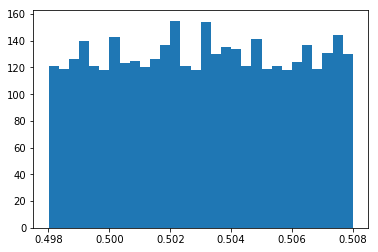

In [19]:
bins = 30
plt.hist(durationtimes, bins=bins)
plt.show()

In [20]:
len(durationtimes[durationtimes < 0.503])

1913

In [21]:
safe_observations = step_observations[step_durationtime < 0.503]

In [22]:
len(safe_observations)

510319

In [23]:
risk_observartions = step_observations[step_durationtime >=0.503]

In [24]:
len(risk_observartions)

389680

In [28]:
safe_actions = step_actions[step_durationtime < 0.503]

In [29]:
risk_actions = step_actions[step_durationtime >= 0.503]

In [33]:
import seaborn as sns

In [30]:
len(risk_actions)

389680

In [6]:
rewards = episode_rewards(step_rewards, step_status)

In [7]:
print("total episodes: %d" % (sum(step_status)))

total episodes: 4345


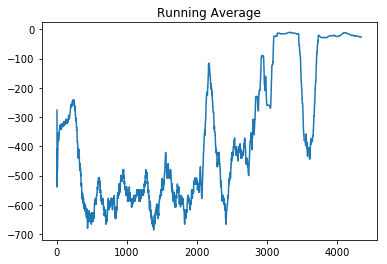

In [8]:
plot_running_avg(rewards)

In [32]:
rewards[3500]

-10.404470865881619

In [33]:
endIndex = np.where(step_status == True)[0]
check_index = endIndex + 13

In [34]:
risk_index = check_index[step_durationtime[check_index] >= 0.503]
risk_observations = step_observations[risk_index]

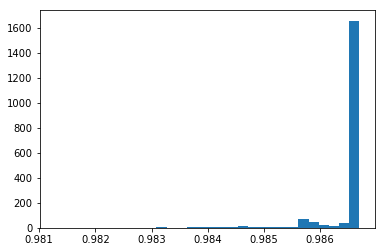

In [35]:
first_var = risk_observations[:, 0]
plt.hist(first_var, bins = 30)
plt.show()

In [36]:
safe_index = check_index[step_durationtime[check_index] < 0.503]
safe_observations = step_observations[safe_index]

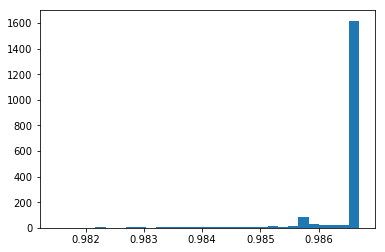

In [37]:
safe_first_var = safe_observations[:, 0]
plt.hist(safe_first_var, bins = 30)
plt.show()

In [130]:
len(safe_index),len(risk_index)

(3300, 3159)

In [131]:
first_var.mean(), safe_first_var.mean()

(1.0147285890885633, 1.0147211307273329)

In [132]:
safe_actions = step_actions[safe_index]
risk_actions = step_actions[risk_index]

In [133]:
sum(safe_actions), sum(risk_actions)

(61, 63)

In [138]:
true_positive = sum(risk_actions)   # brake right
true_negative = len(safe_index) - sum(safe_actions)    # do nothing right
false_positive = sum(safe_actions)      # should not brake but brake
false_negative = len(risk_index) - sum(risk_actions)   # should brake but not brake

In [140]:
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1 = 2.0 * precision * recall / (precision + recall)

In [51]:
risk_index = endIndex + 12

In [14]:
endIndex = np.where(step_status == True)[0]
single_actions = step_actions[endIndex[2500]:endIndex[2501]]
single_observations = step_observations[endIndex[2500]:endIndex[2501]]

def getsingle(step_status, step_actions, step_observations, epindex):
    endIndex = np.where(step_status == True)[0]
    single_actions = step_actions[endIndex[epindex]:endIndex[epindex + 1]]
    single_observations = step_observations[endIndex[epindex]:endIndex[epindex + 1]]
    return single_actions, single_observations

epindex = 2500
single_actions, single_observations = getsingle(step_status,step_actions, step_observations, epindex)

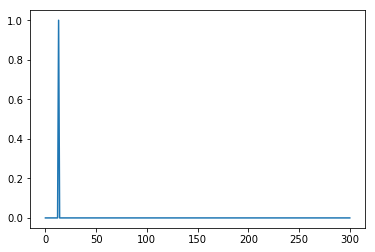

In [15]:
plt.plot(single_actions[:])

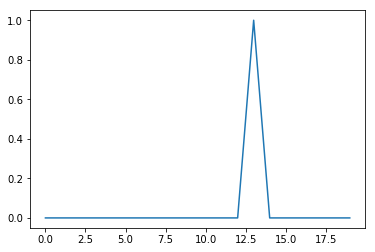

In [16]:
plt.plot(single_actions[:20])

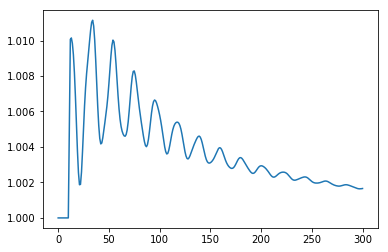

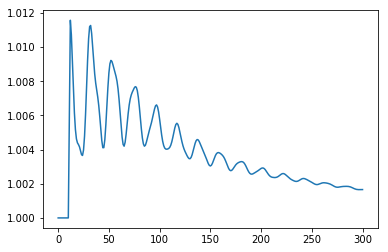

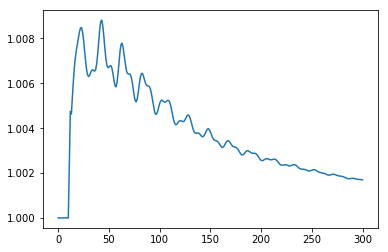

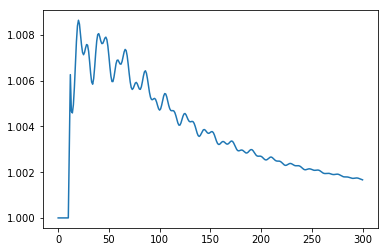

In [25]:
for j in range(4):
    plt.plot(single_observations[:,j])
    plt.show()

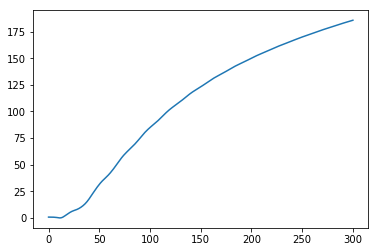

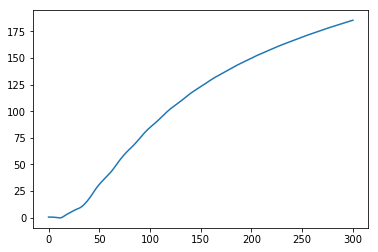

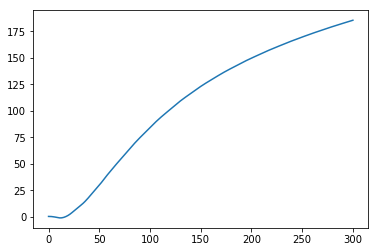

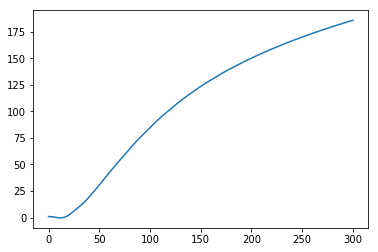

In [48]:
for j in range(4,8):
    plt.plot(single_observations[:,j])
    plt.show()

In [27]:
episode_starttime = step_starttime[endIndex]
episode_durationtime = step_durationtime[endIndex]

In [38]:
episode_durationtime[840:870]

array([ 0.58208367,  0.58752206,  0.58582052,  0.58772269,  0.58354518,
        0.58700318,  0.5873721 ,  0.58705891,  0.58225131,  0.58695699,
        0.5857719 ,  0.58718422,  0.58722837,  0.58582864,  0.58481808,
        0.5876294 ,  0.58618768,  0.58568803,  0.58617137,  0.58494363,
        0.58292308,  0.58300902,  0.58275156,  0.58221235,  0.58706612,
        0.58378984,  0.58420996,  0.58744629,  0.58317531,  0.58685113])

In [40]:
episode_observations[600]

0.58718421720143554

In [43]:
episode_durationtime[600]

0.58406529121656692

## Test and Compare

In [16]:
noise = 0.0 * np.random.randn(4,8,301)
#noise = np.load("./noise.npy")
noise.shape

(4, 8, 301)

In [6]:
from baselines import deepq
import baselines.common.tf_util as U
def test():
    tf.reset_default_graph()
    #act = deepq.load("./previous_model/power_model_multistep_581to585_lr_0.0001_90w.pkl")
    act = deepq.load("./previous_model/power_model_multistep_498to508_lr_0.0001_90w.pkl")
    # power_model_multistep_498to508_lr_0.0001_90w.pkl
    # power_model_multistep_581to585_lr_0.0001_90w.pkl
    with tf.variable_scope("deepq", reuse=True):
        eps = tf.get_variable("eps")
    U.set_value(eps, 0)
    print("Check epsilon is: %f" % U.eval(eps))
    
    obs, done = env._validate(1,2,1.0,0.6), False
    episode_rew = 0
    actions = list()
    observations = list()
    #noise = 0.01 * np.random.randn(4,8,301)
    i = 0
    while not done:

        action = act(obs[None])[0]
        #action = 0
        #oo = (obs[1] + obs[0] - obs[2] - obs[3]) / 2.0
        
        #if 0.0053 < oo < 0.0057:
        #    action = 1

        observations.append(obs)
        actions.append(action)
        obs, rew, done, _ = env.step(action)
        #obs = obs * (1 + noise[:,:,i].flatten())
        i += 1
        
        episode_rew += rew
    print("Episode reward", episode_rew)

    return np.array(actions), np.array(observations)

In [13]:
#from baselines import deepq
#import baselines.common.tf_util as U
def manual_test():
    tf.reset_default_graph()
    act = deepq.load("./previous_model/power_model_400to766_bus6to9_lr_5e-05_90w.pkl")
    with tf.variable_scope("deepq", reuse=True):
        eps = tf.get_variable("eps")
    U.set_value(eps, 0)
    print("Check epsilon is: %f" % U.eval(eps))
    
    obs, done = env._validate(1,2,1.0,0.498), False
    episode_rew = 0
    actions = list()
    observations = list()
    cnt = 0
    while not done:
  
        #action = act(obs[None])[0]
        action = 0
        
        #if cnt ==12:
        #    action = 1
        
        
        observations.append(obs)
        actions.append(action)
        obs, rew, done, _ = env.step(action)
        episode_rew += rew
        cnt += 1
    print("Episode reward", episode_rew)

    return np.array(actions), np.array(observations)

In [7]:
test_actions, test_observations = test()
#test_actions, test_observations = manual_test()

INFO:tensorflow:Restoring parameters from /tmp/tmp95dne35h/model
Check epsilon is: 0.000000
Episode reward -2.308749357813859


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

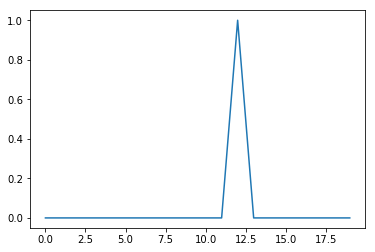

In [9]:
plt.plot(test_actions[:20])
test_actions[:20]


In [5]:
test_actions_ai = test_actions
test_observations_ai = test_observations

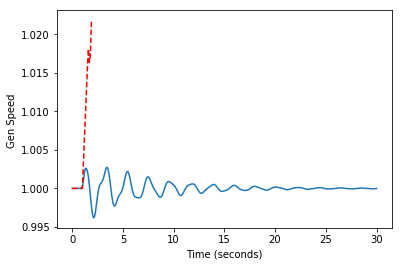

In [38]:
plt.xlabel('Time (seconds)')  
plt.ylabel('Gen Speed ') 
t1 = np.arange(0,30.1,0.1)

plt.plot(t1, (test_observations_ai[:,0] - (test_observations_ai[:,0]+test_observations_ai[:,1]
                                           +test_observations_ai[:,2]+test_observations_ai[:,3])/4+1.0))
#plt.show()

t2 = np.arange(0,2,0.1)
test_observations_norm = []
for i in range(0,20):
    test_observations_norm.append(test_observations[i,5]-0.55)
    
plt.plot(t2, (test_observations[:,0] - (test_observations[:,0]+test_observations[:,1]
                                           +test_observations[:,2]+test_observations[:,3])/4+1.0), 'r--')
#plt.plot(t2, test_observations_norm , 'r--')
#plt.plot(t2, (test_observations[:,5] - test_observations[:,6]) , 'r--')
    
plt.show()

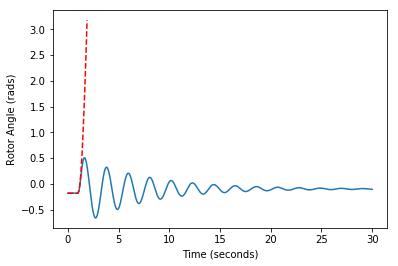

In [42]:
plt.xlabel('Time (seconds)')  
plt.ylabel('Rotor Angle (rads)') 
t1 = np.arange(0,30.1,0.1)
#plt.plot(t1, (test_observations_ai[:,5] - test_observations_ai[:,6]))
plt.plot(t1, ( test_observations_ai[:,4] + test_observations_ai[:,5] - 
              test_observations_ai[:,6] - test_observations_ai[:,7]) / 2, ) 
#plt.show()

t2 = np.arange(0,2,0.1)
test_observations_norm = []
for i in range(0,20):
    test_observations_norm.append(test_observations[i,5]-0.55)
    
plt.plot(t2, ( test_observations[:,4] + test_observations[:,5] - 
              test_observations[:,6] - test_observations[:,7]) / 2, 'r--')  
#plt.plot(t2, test_observations_norm , 'r--')
#plt.plot(t2, (test_observations[:,5] - test_observations[:,6]) , 'r--')
    
plt.show()

In [32]:
#len((test_observations[:,1] ))
test_observations[1,5]

0.45873956916471925

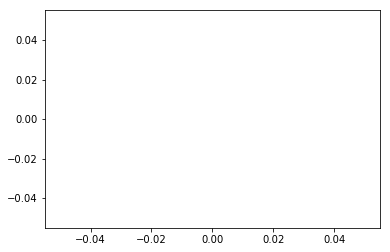

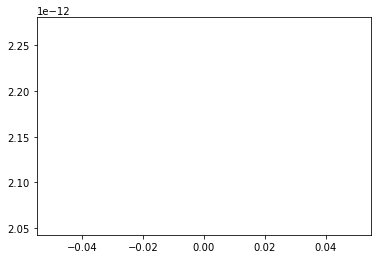

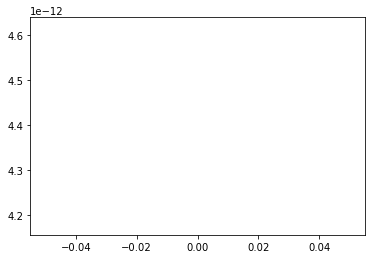

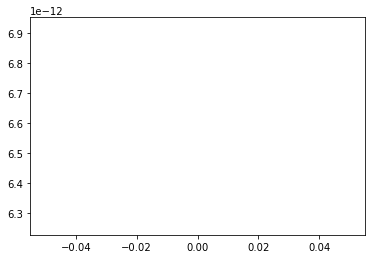

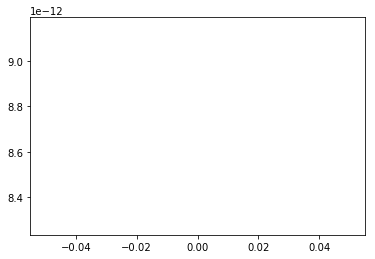

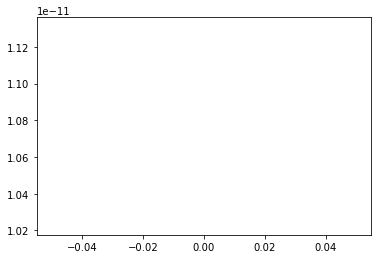

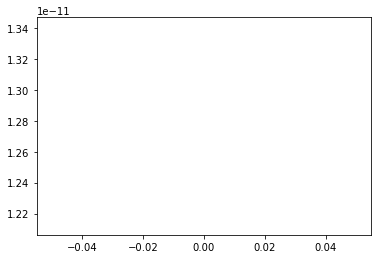

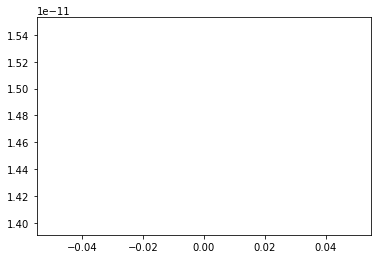

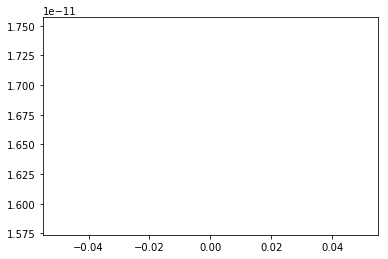

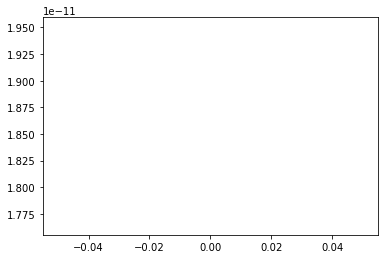

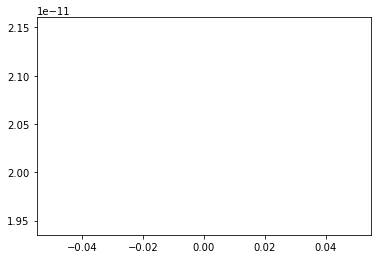

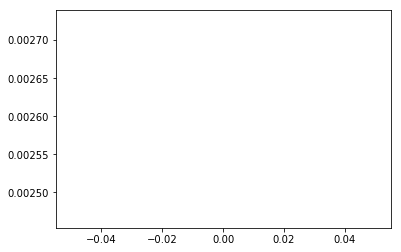

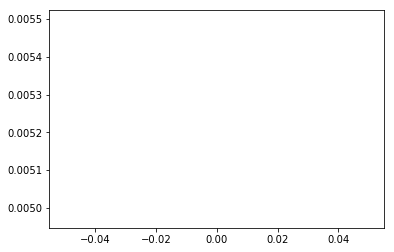

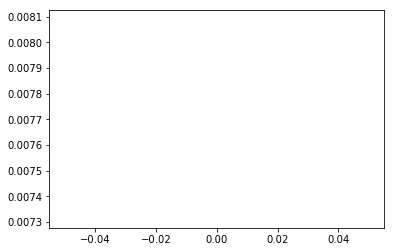

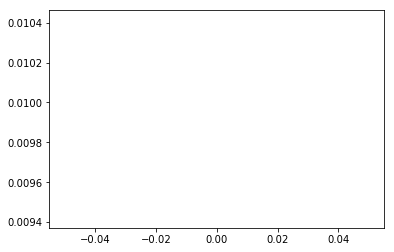

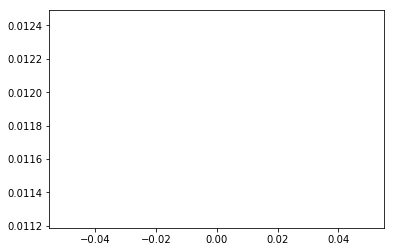

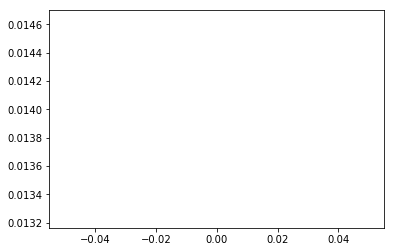

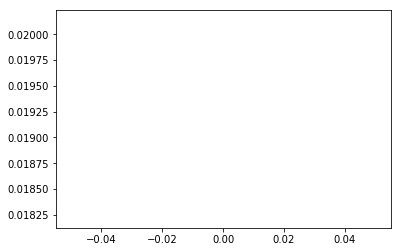

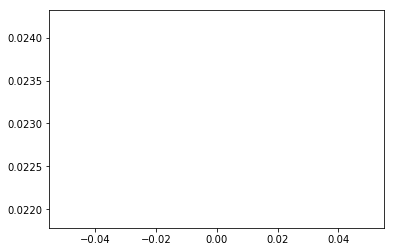

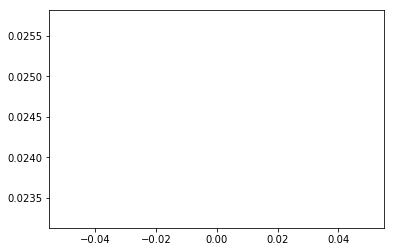

In [24]:
#t2 = np.arange(0,2,0.1)
#plt.plot(t2, ( test_observations[:,1] + test_observations[:,0] - test_observations[:,2] - test_observations[:,3]) / 2, 'r--')
for i in range(0,20):
    #plt.plot(t2[i], test_observations[i,1]-1.0 , 'r--')
    plt.plot( test_observations[i,1] - 1.0, 'r--')
    plt.show()

In [50]:
a = (test_observations[:,0] + test_observations[:,1]) / 2 - ((test_observations[:, 2] + test_observations[:,3])/2)
b = (test_observations[:,4] + test_observations[:,5]) / 2 - ((test_observations[:,6] + test_observations[:,7])/2)

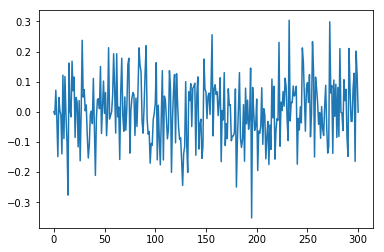

In [51]:
plt.plot(a)

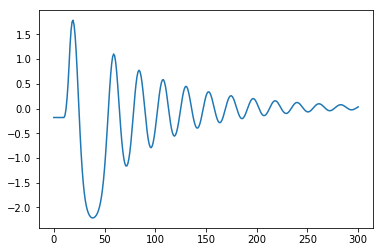

In [40]:
plt.plot(b)

In [43]:
print(np.min(a), np.max(a))
print(np.min(b), np.max(b))

-0.0143366423374 0.0131632746174
-2.21397636766 1.78709326277


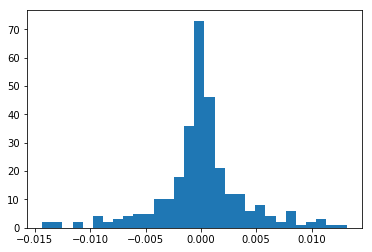

In [44]:
bins = 30
plt.hist(a, bins=bins)
plt.show()

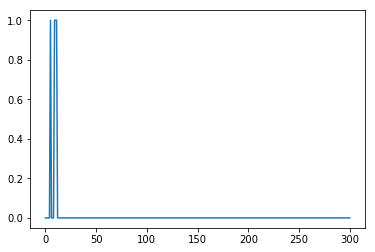

In [54]:
plt.plot(test_actions[:])

In [48]:
test_actions[:50]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

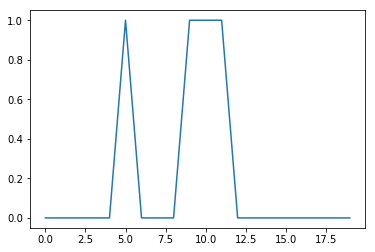

In [55]:
plt.plot(test_actions[:20])

In [45]:
list(range(0,32,8))

[0, 8, 16, 24]

In [47]:
print(test_observations[12,0:32:8])
print(test_observations[13,0:32:8])
print(test_observations[14,0:32:8])

[ 1.          1.          1.00573297  1.01158376]
[ 1.          1.00573297  1.01158376  1.01740693]
[ 1.00573297  1.01158376  1.01740693  1.02319975]


In [48]:
print(test_observations[15,0:32:8])
print(test_observations[16,0:32:8])
print(test_observations[17,0:32:8])

[ 1.01158376  1.01740693  1.02319975  1.0289614 ]
[ 1.01740693  1.02319975  1.0289614   1.02689473]
[ 1.02319975  1.0289614   1.02689473  1.02569184]


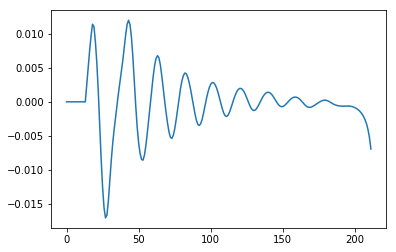

In [68]:
plt.plot((test_observations[:,1] + test_observations[:,0] - test_observations[:,2] - test_observations[:,3]) / 2)

In [35]:
aa = (test_observations[:,1] + test_observations[:,0] - test_observations[:,2] - test_observations[:,3]) / 2
np.argmax(aa)

13

In [20]:
test_observations.shape

(301, 32)

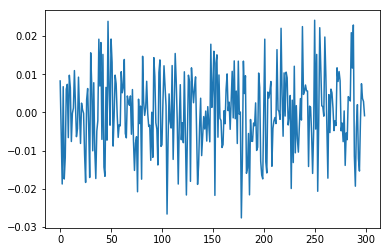

In [21]:
plt.plot(0.01 * np.random.randn(1,300).flatten())

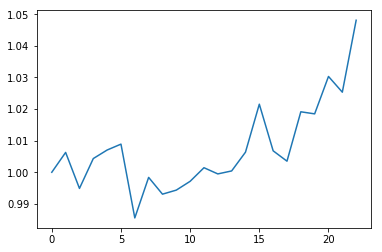

In [48]:
for j in range(0,1):
    plt.plot(test_observations[:,j])
    plt.show()

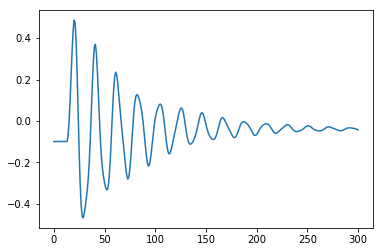

In [22]:
plt.plot(test_observations[:,5] - test_observations[:,6])

In [9]:
test_actions_85, test_observations_85 = test()

INFO:tensorflow:Restoring parameters from /tmp/tmpzklz3oym/model
Check epsilon is: 0.000000
Episode reward -2.260483576785169


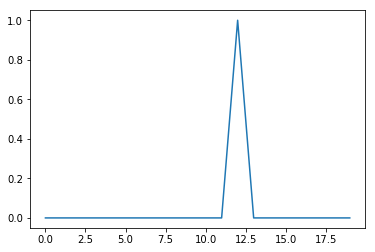

In [10]:
plt.plot(test_actions_85[:20])

In [11]:
print(np.where(test_actions == 1))

(array([12]),)


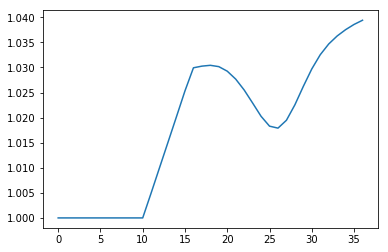

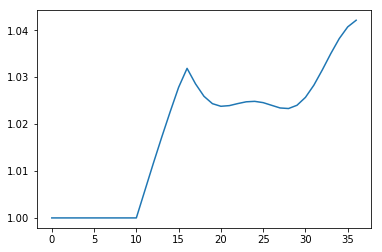

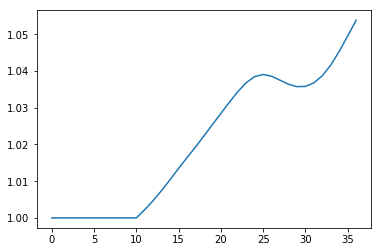

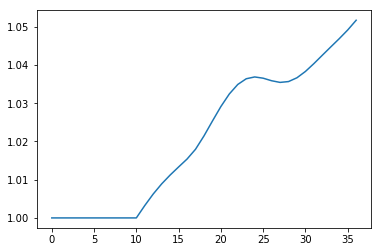

In [17]:
for j in range(4):
    plt.plot(test_observations_585[:,j])
    plt.show()

In [29]:
manual_test_actions, manual_test_observations = manual_test()

INFO:tensorflow:Restoring parameters from /tmp/tmp82vujav4/model
Check epsilon is: 0.000000
Episode reward -4.181683084037992


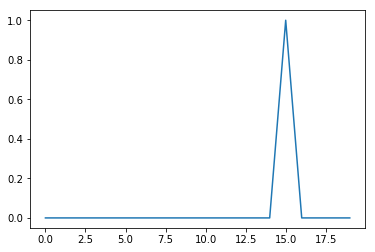

In [19]:
plt.plot(manual_test_actions[:20])

In [23]:
(test_observations[:36,0] - test_observations_585[:36, 0])

0.10087130812440037

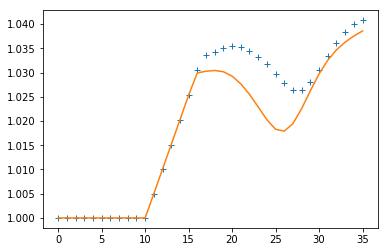

In [26]:
x = range(36)
plt.plot(x, test_observations[:36, 0], '+',x, test_observations_585[:36, 0])

In [54]:
for i in range(10):
    obs = env._validate(1,8,1.0,0.585 + i * 1.0 / 100)
    print(obs)

[ 1.          1.          1.          1.          0.65307907  0.45873957
  0.55793684  0.91728261]
[ 1.          1.          1.          1.          0.65307907  0.45873957
  0.55793684  0.91728261]
[ 1.          1.          1.          1.          0.65307907  0.45873957
  0.55793684  0.91728261]
[ 1.          1.          1.          1.          0.65307907  0.45873957
  0.55793684  0.91728261]
[ 1.          1.          1.          1.          0.65307907  0.45873957
  0.55793684  0.91728261]
[ 1.          1.          1.          1.          0.65307907  0.45873957
  0.55793684  0.91728261]
[ 1.          1.          1.          1.          0.65307907  0.45873957
  0.55793684  0.91728261]
[ 1.          1.          1.          1.          0.65307907  0.45873957
  0.55793684  0.91728261]
[ 1.          1.          1.          1.          0.65307907  0.45873957
  0.55793684  0.91728261]
[ 1.          1.          1.          1.          0.65307907  0.45873957
  0.55793684  0.91728261]


In [5]:
test_model_observation = np.array([1.01805634,1.02437257,1.03878494,1.03628637,11.0115433,
                                   10.76867162,10.3089823,10.67577841])
test_model_observation1 = np.array([1.,1.,1.,1.,0.65307907,0.45873957,0.55793684,0.91728261])

obs146 = np.array([1.02736745,1.0275622,1.02619083,1.02613306,166.78751976,166.61068333,166.13746806,166.67939941])


def test_model():
    tf.reset_default_graph()
    act = deepq.load("power_model.pkl")
    with tf.variable_scope("deepq", reuse=True):
        eps = tf.get_variable("eps")
    U.set_value(eps, 0)
    
    actions = list()
    
    for i in range(10):
        action = act(obs146[None])[0]
        actions.append(action)

    return np.array(actions)

In [33]:
#aa1 = test_model()
#for i in range(10):
#    aa = test_model()
#    x = aa - aa1
#    print(np.where(x==-1))

In [33]:
obs_146 = test_observations[146]
print(obs_146)

[   1.02736745    1.0275622     1.02619083    1.02613306  166.78751976
  166.61068333  166.13746806  166.67939941]


In [24]:
def test_model_singleobs(obs):
    tf.reset_default_graph()
    act = deepq.load("power_model.pkl")
    with tf.variable_scope("deepq", reuse=True):
        eps = tf.get_variable("eps")
    U.set_value(eps, 0)
    return act(obs[None])[0]

def test_fixed_actions():
    obs, done = env._validate(1,8,1.0,0.583), False
    
    episode_rew = 0
    observations = list()
    actions = list()
    act_index = 0
    while not done:
        if act_index in [0,1,36]:
            action = 1
        else:
            action = 0

        #action = input_actions[act_index]
        observations.append(obs)
        actions.append(action)
        obs, rew, done, _ = env.step(action)
        episode_rew += rew
        act_index += 1
    print("Episode reward", episode_rew)

    return np.array(actions), np.array(observations)

In [35]:
#tf.reset_default_graph()
test_actions, test_observations = test()

INFO:tensorflow:Restoring parameters from /tmp/tmpcrbmwlhy/model
Check epsilon is: 0.000000
Episode reward -602.2408296623959


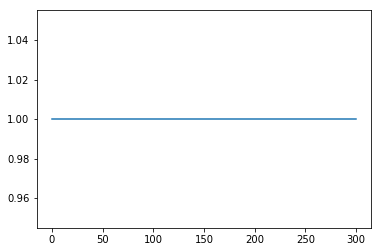

In [36]:
plt.plot(test_actions[:])

In [25]:
fixed_actions, fixed_observations = test_fixed_actions()

Episode reward -6.7853703750717695


In [14]:
np.save(os.path.join(datafolder, "step_actions_583_37"), np.array(fixed_actions))
np.save(os.path.join(datafolder, "step_observations_583_37"), np.array(fixed_observations))

In [17]:
single_test_observation = fixed_observations[36]
single_test_observation

array([  1.03935205,   1.04368277,   1.04364682,   1.04222192,
        18.7969916 ,  18.79677411,  20.73117377,  21.29175338])

In [18]:
test_model_singleobs(single_test_observation)

INFO:tensorflow:Restoring parameters from /tmp/tmpmyuiu64f/model


0

In [26]:
test_model_singleobs(fixed_observations[1])

INFO:tensorflow:Restoring parameters from /tmp/tmp7b9efyuz/model


1

In [32]:
#res = list()
#for i in range(100):
#    res.append(test_model_singleobs(test_observations[145]))
#print(sum(res))
#tf.trainable_variables()

In [19]:
#np.save(os.path.join(datafolder, "step_actions_583"), np.array(test_actions))
#np.save(os.path.join(datafolder, "step_observations_583"), np.array(test_observations))

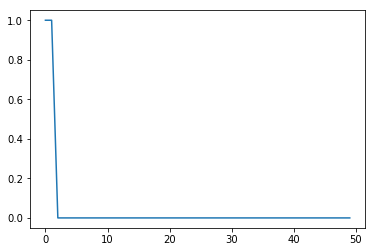

In [31]:
plt.plot(test_actions)

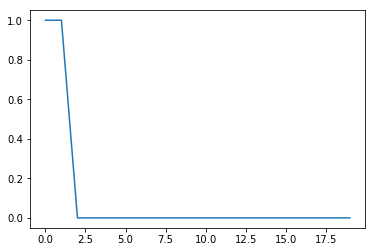

In [9]:
plt.plot(test_actions[:20])

In [18]:
test_actions[:34]

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [19]:
test_actions_1[:34]

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
for i in range(8):
    delta_ob = test_observations[:50,i] - test_observations_1[0:50,i]
    print(i, delta_ob)

0 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00  -7.05605310e-05  -7.51467187e-05  -6.22296405e-05
  -2.55087737e-05   4.16945212e-05   1.36325108e-04   2.43437105e-04
   3.39310738e-04   3.99951700e-04   4.11622054e-04   3.76102165e-04
   3.09831208e-04   2.39093029e-04   1.76740690e-04   6.62325330e-05
  -2.61517504e-04  -1.02108555e-03]
1 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.0000000

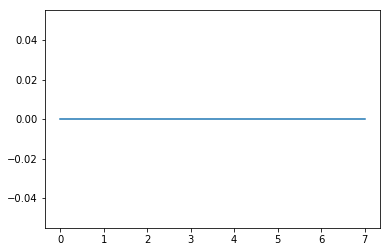

In [15]:
plt.plot(delta_ob)

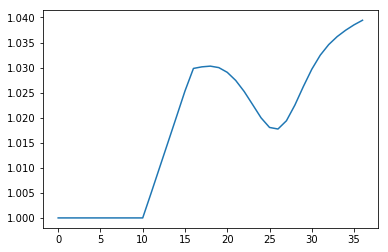

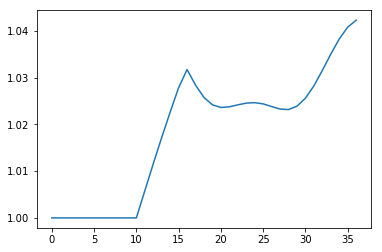

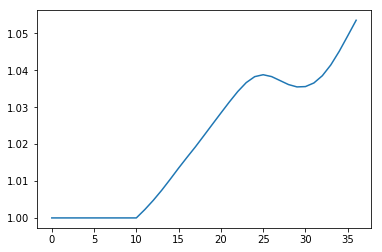

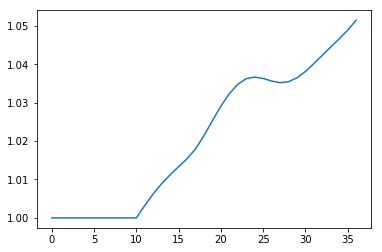

In [83]:
for j in range(4):
    plt.plot( test_observations[:,j])
    plt.show()

In [48]:
print(test_observations[0])

[ 1.          1.          1.          1.          0.65307907  0.45873957
  0.55793684  0.91728261]


In [49]:
print(test_observations[1])

[ 0.99987471  0.99978727  0.99922117  0.99868958  0.65121423  0.45550031
  0.54610684  0.89659443]


In [ ]:
[ 1.          1.          1.          1.          0.65307907  0.45873957
  0.55793684  0.91728261]

In [ ]:
[ 0.99987471  0.99978727  0.99922117  0.99868958  0.65121423  0.45550031
  0.54610684  0.89659443]

In [84]:
print(test_observations[25])

[  1.01805634   1.02437257   1.03878494   1.03628637  11.0115433
  10.76867162  10.3089823   10.67577841]


In [85]:
test_observations[25].shape

(8,)

In [27]:
step_actions_583 = np.load(os.path.join(datafolder, "step_actions_583.npy"))
step_observations_583 = np.load(os.path.join(datafolder, "step_observations_583.npy"))

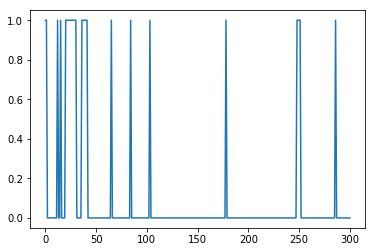

In [28]:
plt.plot(step_actions_583)

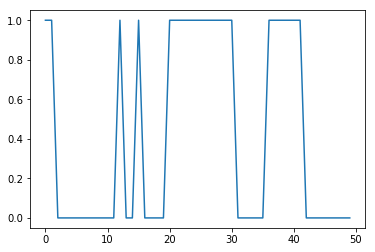

In [30]:
plt.plot(step_actions_583[:50])

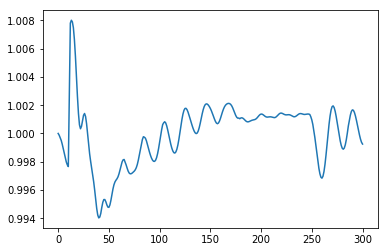

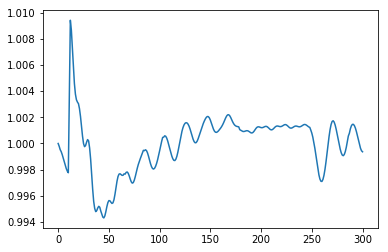

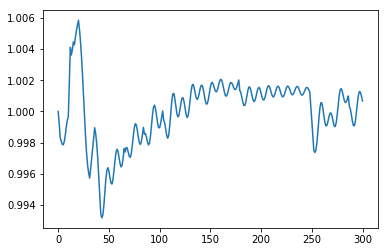

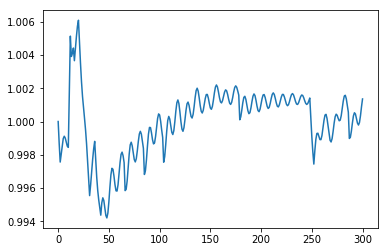

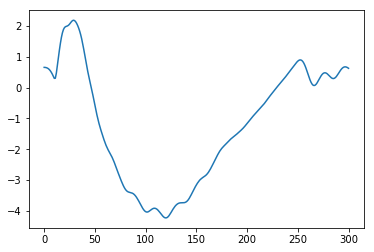

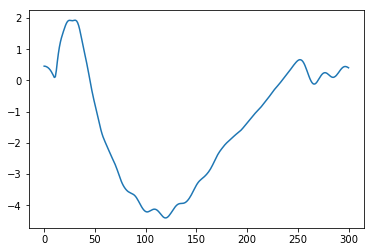

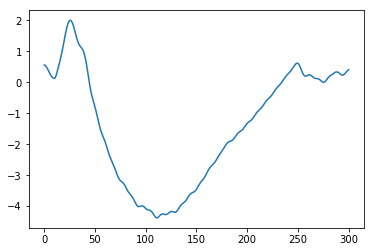

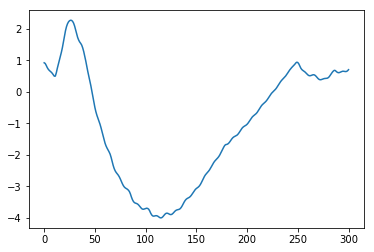

In [29]:
for j in range(8):
    plt.plot(step_observations_583[:,j])
    plt.show()

In [34]:
def test_no_actions():
    obs, done = env._validate(1,8,1.0,0.583), False
    
    episode_rew = 0
    observations = list()
    actions = list()
    act_index = 0
    while not done:
        action = 0
        observations.append(obs)
        actions.append(action)
        obs, rew, done, _ = env.step(action)
        episode_rew += rew
        act_index += 1
    print("Episode reward", episode_rew)

    return np.array(actions), np.array(observations)

In [35]:
_, noaction_obs = test_no_actions()

Episode reward -2000.2401833204337


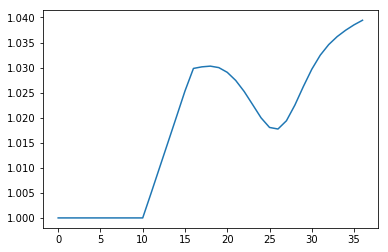

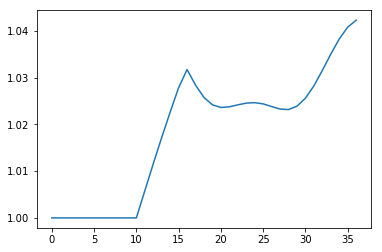

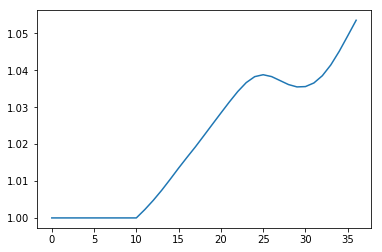

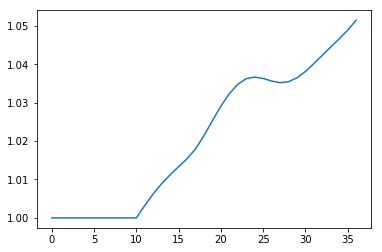

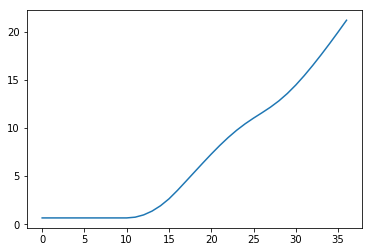

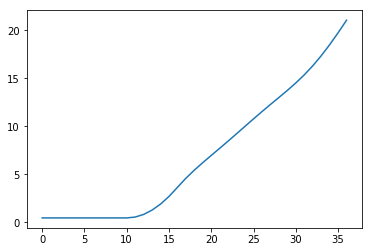

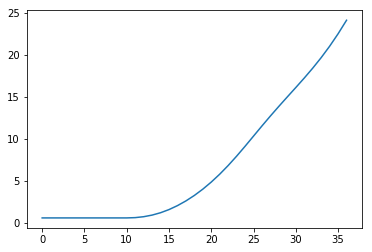

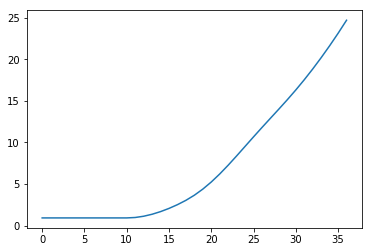

In [36]:
for j in range(8):
    plt.plot(noaction_obs[:,j])
    plt.show()